In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import xgboost as xgb
import numpy as np 

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from IPython.display import display
from sklearn import tree

In [2]:
# !pip install xgboost


# Exploring "games" csv

In [3]:
#load data
games = pd.read_csv('Data/games.csv', dtype = {'GAME_ID': str, 'HOME_TEAM_ID': str, 'VISITOR_TEAM_ID': str})
games.head(3)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,23.0,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,...,24.0,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,...,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0


In [4]:
games.dtypes

GAME_DATE_EST        object
GAME_ID              object
GAME_STATUS_TEXT     object
HOME_TEAM_ID         object
VISITOR_TEAM_ID      object
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object

In [5]:
games.loc[games['HOME_TEAM_ID']==1610612753,:].sort_values(by='GAME_DATE_EST')

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS


In [6]:
games = games.dropna()

In [7]:
games = games.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [8]:
bulls = games.loc[games['HOME_TEAM_ID']==1610612753,:].sort_values(by='GAME_DATE_EST')

In [9]:
bulls = bulls[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS'
]]

In [10]:
bulls.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,HOME_TEAM_WINS


In [11]:
games['HOME_TEAM_ID'].unique()

array(['1610612753', '1610612764', '1610612763', '1610612754',
       '1610612761', '1610612752', '1610612738', '1610612740',
       '1610612760', '1610612743', '1610612756', '1610612745',
       '1610612742', '1610612758', '1610612746', '1610612755',
       '1610612739', '1610612766', '1610612748', '1610612749',
       '1610612750', '1610612762', '1610612737', '1610612751',
       '1610612765', '1610612741', '1610612747', '1610612757',
       '1610612759', '1610612744'], dtype=object)

In [17]:
home_var = {'GAME_DATE_EST': [], 
           'GAME_ID': [],
           'HOME_TEAM_ID': [],
           'FG_PCT_home': [],
           'FT_PCT_home': [],
           'FG3_PCT_home': [], 'AST_home': [], 'REB_home': [],'HOME_TEAM_WINS':[]
           }


home_data = pd.DataFrame(home_var)

for team in games['HOME_TEAM_ID'].unique():
    

    temp_df = games.loc[games['HOME_TEAM_ID']==team,:].sort_values(by='GAME_DATE_EST')

    temp_df = temp_df[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']]
    
#     print(bulls.rolling(2).mean())
    temp_df['FG_PCTHOME_ROllING']=temp_df['FG_PCT_home'].rolling(2).mean()
    temp_df['FT_PCTHOME_ROllING']=temp_df['FT_PCT_home'].rolling(2).mean()
    temp_df['FG3_PCTHOME_ROllING']=temp_df['FG3_PCT_home'].rolling(2).mean()
    temp_df['AST_home_ROllING']=temp_df['AST_home'].rolling(2).mean()
    temp_df['REB_home_ROllING']=temp_df['REB_home'].rolling(2).mean()
#     print(bulls.head())
    home_data = home_data.append(temp_df)
    
    
home_data = home_data.dropna()
home_data = home_data.drop(columns = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home'])
home_data.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,HOME_TEAM_WINS,FG_PCTHOME_ROllING,FT_PCTHOME_ROllING,FG3_PCTHOME_ROllING,AST_home_ROllING,REB_home_ROllING
16017,2003-11-01,20300028,1610612753,0.0,0.400,0.8050,0.3665,17.0,34.5
16002,2003-11-03,20300041,1610612753,0.0,0.320,0.7885,0.3335,14.5,40.0
15992,2003-11-05,20300054,1610612753,0.0,0.355,0.7575,0.3250,17.0,41.5
15979,2003-11-07,20300069,1610612753,0.0,0.424,0.6190,0.3470,19.0,35.0
15941,2003-11-12,20300105,1610612753,0.0,0.420,0.6025,0.2720,18.5,40.5


In [18]:
#creating test and train data
home_data['is_train'] = np.random.uniform(0,1,len(home_data)) <= .75
#view the top five rows
home_data.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,HOME_TEAM_WINS,FG_PCTHOME_ROllING,FT_PCTHOME_ROllING,FG3_PCTHOME_ROllING,AST_home_ROllING,REB_home_ROllING,is_train
16017,2003-11-01,20300028,1610612753,0.0,0.400,0.8050,0.3665,17.0,34.5,False
16002,2003-11-03,20300041,1610612753,0.0,0.320,0.7885,0.3335,14.5,40.0,True
15992,2003-11-05,20300054,1610612753,0.0,0.355,0.7575,0.3250,17.0,41.5,True
15979,2003-11-07,20300069,1610612753,0.0,0.424,0.6190,0.3470,19.0,35.0,True
15941,2003-11-12,20300105,1610612753,0.0,0.420,0.6025,0.2720,18.5,40.5,True


In [19]:
#creating dataframes with test rows and training rows
train, test = home_data[home_data['is_train']==True], home_data[home_data['is_train']==False]

#Show number of observations for train and test data
print('training data observations: ',len(train))
print('testing data observations: ',len(test))

training data observations:  17625
testing data observations:  5766


In [20]:
features = home_data.columns[5:9]
features


Index(['FT_PCTHOME_ROllING', 'FG3_PCTHOME_ROllING', 'AST_home_ROllING',
       'REB_home_ROllING'],
      dtype='object')

In [21]:
y = pd.factorize(train['HOME_TEAM_WINS'])[0]
#Viewing Target
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [23]:
from sklearn.ensemble import RandomForestClassifier
#Creating a random forest classifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
#Training the classifier
clf.fit(train[features],y)

RandomForestClassifier(n_jobs=2, random_state=0)

In [24]:
clf.predict(test[features])

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [25]:
clf.predict_proba(test[features])[0:10]

array([[0.76, 0.24],
       [0.52, 0.48],
       [0.82, 0.18],
       [0.49, 0.51],
       [0.39, 0.61],
       [0.23, 0.77],
       [0.58, 0.42],
       [0.62, 0.38],
       [0.65, 0.35],
       [0.7 , 0.3 ]])

In [27]:
pred = clf.predict(test[features])
pred[0:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [28]:
test['HOME_TEAM_WINS']

16017    0.0
15856    0.0
15832    0.0
15803    0.0
15540    1.0
        ... 
626      0.0
597      1.0
447      0.0
432      0.0
285      1.0
Name: HOME_TEAM_WINS, Length: 5766, dtype: float64

In [29]:
#Creating the confusion matrix
pd.crosstab(test['HOME_TEAM_WINS'], pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0.0,1102,1234
1.0,907,2523


In [30]:
accuracy = (1102 + 2523) / (1102 + 1234 + 907 + 2523)
print(accuracy)

0.6286853971557406


In [85]:
away_var = {'GAME_DATE_EST': [], 
           'GAME_ID': [],
           'VISITOR_TEAM_ID': [],
           'FG_PCT_away': [],
           'FT_PCT_away': [],
           'FG3_PCT_away': [], 'AST_away': [], 'REB_away': []
           }


away_data = pd.DataFrame(away_var)

for team in games['VISITOR_TEAM_ID'].unique():
    

    temp_df = games.loc[games['VISITOR_TEAM_ID']==team,:].sort_values(by='GAME_DATE_EST')

    temp_df = temp_df[['GAME_DATE_EST', 'GAME_ID', 'VISITOR_TEAM_ID', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']]
    
#     print(bulls.rolling(2).mean())
    temp_df['FG_PCTAWAY_ROllING']=temp_df['FG_PCT_away'].rolling(2).mean()
    temp_df['FT_PCTAWAY_ROllING']=temp_df['FT_PCT_away'].rolling(2).mean()
    temp_df['FG3_PCTAWAY_ROllING']=temp_df['FG3_PCT_away'].rolling(2).mean()
    temp_df['AST_away_ROllING']=temp_df['AST_away'].rolling(2).mean()
    temp_df['REB_away_ROllING']=temp_df['REB_away'].rolling(2).mean()
#     print(bulls.head())
    away_data = away_data.append(temp_df)

away_data = away_data.dropna()
away_data = away_data.drop(columns = ['FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away'])
away_data.head()

,GAME_DATE_EST,GAME_ID,VISITOR_TEAM_ID,FG_PCTAWAY_ROllING,FT_PCTAWAY_ROllING,FG3_PCTAWAY_ROllING,AST_away_ROllING,REB_away_ROllING
14663,2004-11-10,20400064,1610612766,0.4440,0.7320,0.3335,22.0,41.0
14648,2004-11-12,20400074,1610612766,0.4220,0.6510,0.3420,23.0,42.0
14593,2004-11-20,20400131,1610612766,0.3825,0.5775,0.3835,18.0,42.0
14583,2004-11-21,20400140,1610612766,0.4155,0.6650,0.5280,21.0,44.0
14543,2004-11-26,20400176,1610612766,0.4280,0.7565,0.4445,24.0,43.5


In [86]:
clean_data = pd.merge(home_data, away_data, how="inner", on=["GAME_DATE_EST", "GAME_ID"])

In [87]:
clean_data = clean_data.drop(columns = ["GAME_DATE_EST"])
clean_data.head()

,GAME_ID,HOME_TEAM_ID,HOME_TEAM_WINS,FG_PCTHOME_ROllING,FT_PCTHOME_ROllING,FG3_PCTHOME_ROllING,AST_home_ROllING,REB_home_ROllING,VISITOR_TEAM_ID,FG_PCTAWAY_ROllING,FT_PCTAWAY_ROllING,FG3_PCTAWAY_ROllING,AST_away_ROllING,REB_away_ROllING
0,20300028,1610612753,0.0,0.400,0.8050,0.3665,17.0,34.5,1610612765,0.4260,0.8105,0.3930,16.0,45.0
1,20300041,1610612753,0.0,0.320,0.7885,0.3335,14.5,40.0,1610612752,0.4055,0.9395,0.0800,21.5,43.0
2,20300054,1610612753,0.0,0.355,0.7575,0.3250,17.0,41.5,1610612741,0.4110,0.8350,0.3525,17.5,39.0
3,20300069,1610612753,0.0,0.424,0.6190,0.3470,19.0,35.0,1610612750,0.4500,0.7775,0.4645,22.0,41.5
4,20300105,1610612753,0.0,0.420,0.6025,0.2720,18.5,40.5,1610612763,0.4400,0.7560,0.4190,20.0,37.0


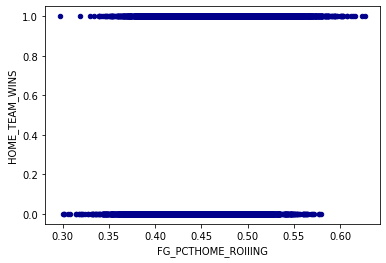

In [88]:
ax1 = clean_data.plot.scatter(x='FG_PCTHOME_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkBlue')
#if the home team shoots a rolling average of 58% of field goals scored the past two games, they're are probably going to win the game.
# if the home team scores an a rolling average of less than 33%, they are probably lost that game.
#Otherwise, its a toss up.

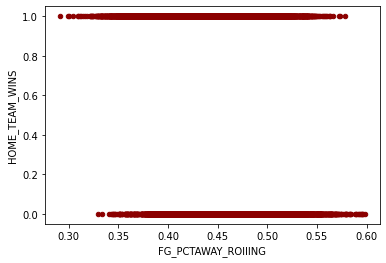

In [89]:
ax1 = clean_data.plot.scatter(x='FG_PCTAWAY_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkRed')

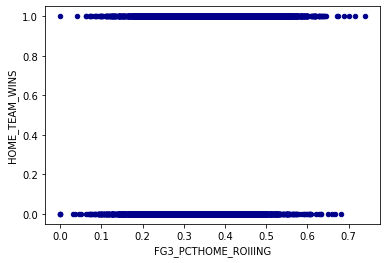

In [90]:
ax1 = clean_data.plot.scatter(x='FG3_PCTHOME_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkBlue')

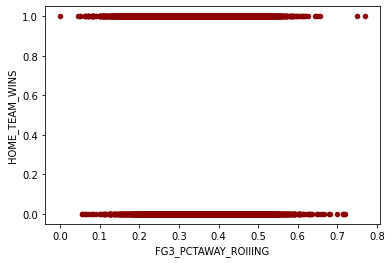

In [91]:
ax1 = clean_data.plot.scatter(x='FG3_PCTAWAY_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkRed')

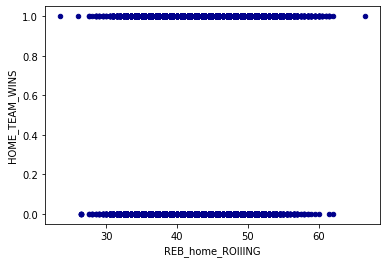

In [92]:
ax1 = clean_data.plot.scatter(x='REB_home_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkBlue')

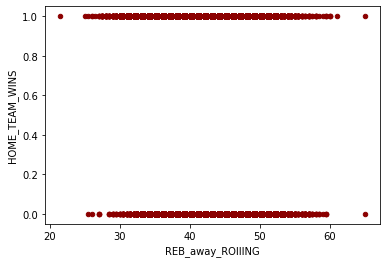

In [93]:
ax1 = clean_data.plot.scatter(x='REB_away_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkRed')

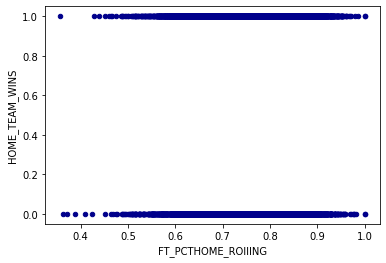

In [94]:
ax1 = clean_data.plot.scatter(x='FT_PCTHOME_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkBlue')

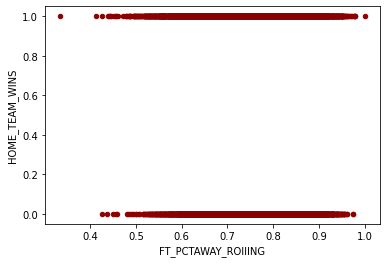

In [95]:
ax1 = clean_data.plot.scatter(x='FT_PCTAWAY_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkRed')

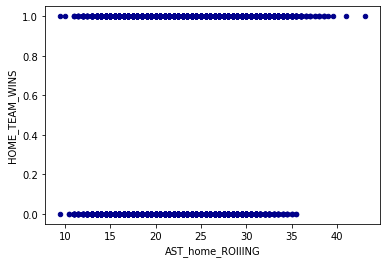

In [96]:
ax1 = clean_data.plot.scatter(x='AST_home_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkBlue')

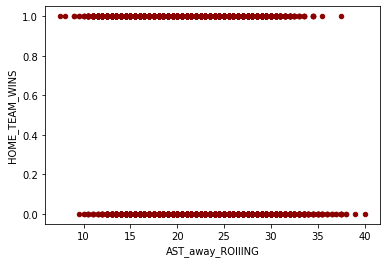

In [97]:
ax1 = clean_data.plot.scatter(x='AST_away_ROllING',
                      y='HOME_TEAM_WINS',
                      c='DarkRed')

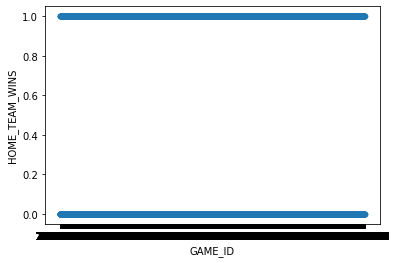

In [98]:
ax2 = clean_data.plot.scatter(x='GAME_ID',
                      y='HOME_TEAM_WINS')

In [ ]:
# Logistical Regression

In [24]:
# Assign X (data) and y (target)
X = clean_data.drop("HOME_TEAM_WINS", axis=1)
y = clean_data["HOME_TEAM_WINS"].values.reshape(-1, 1)
print(X.shape, y.shape)

(23380, 13) (23380, 1)


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


X_train.head()

,GAME_ID,HOME_TEAM_ID,FG_PCTHOME_ROllING,FT_PCTHOME_ROllING,FG3_PCTHOME_ROllING,AST_home_ROllING,REB_home_ROllING,VISITOR_TEAM_ID,FG_PCTAWAY_ROllING,FT_PCTAWAY_ROllING,FG3_PCTAWAY_ROllING,AST_away_ROllING,REB_away_ROllING
17038,20301150,1610612737,0.4565,0.8425,0.3185,22.0,44.0,1610612738,0.4035,0.6395,0.3250,17.0,40.0
8299,21500236,1610612756,0.4735,0.7480,0.3850,23.0,37.0,1610612744,0.5480,0.6845,0.5480,33.5,49.5
20996,20300346,1610612757,0.5115,0.6465,0.3910,30.5,40.5,1610612749,0.5125,0.7315,0.3775,28.0,39.5
11193,21100065,1610612746,0.4965,0.6125,0.3585,25.5,34.5,1610612757,0.3885,0.8155,0.2925,20.5,43.0
19712,41000301,1610612741,0.4615,0.8000,0.3810,22.0,41.0,1610612748,0.4570,0.9465,0.3030,10.5,39.0


In [26]:
# Create the scalers using only the training data!
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)

In [27]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [28]:
# create your model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [29]:
# Fit (train) or model using the training data
classifier.fit(X_train_scaled, y_train)

C:\Users\sjrya\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [30]:
# Validate the model using the .score() method
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.7583689763330482
Testing Data Score: 0.7563729683490162


In [ ]:
# inputs match up - home team / away team 
# query latest stats from api 
# latest rolling averages calculation
# retrain model 
# input user input - output hometeam wins

In [ ]:
# XGBOOST

In [31]:
# create your model
model = XGBClassifier()

In [32]:
y_pred= classifier.predict(X_test_scaled)

In [33]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.])

In [34]:
y_test

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]])

In [35]:
(y_pred == y_test).sum()/len(y_pred)

3067.663473053892

In [36]:
# TREE

In [37]:
# Fit (train) using the training data
model.fit(X_train_scaled, y_train)

C:\Users\sjrya\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\sjrya\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[11:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
# Validate the model using the test data
predictions = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.7421727972626176


In [39]:
target = clean_data["HOME_TEAM_WINS"]
target_names = ["loss", "win"]


In [40]:
data_1 = clean_data.drop("HOME_TEAM_WINS", axis=1)
feature_names = data_1.columns
data_1.head()

,GAME_ID,HOME_TEAM_ID,FG_PCTHOME_ROllING,FT_PCTHOME_ROllING,FG3_PCTHOME_ROllING,AST_home_ROllING,REB_home_ROllING,VISITOR_TEAM_ID,FG_PCTAWAY_ROllING,FT_PCTAWAY_ROllING,FG3_PCTAWAY_ROllING,AST_away_ROllING,REB_away_ROllING
0,20300028,1610612753,0.400,0.8050,0.3665,17.0,34.5,1610612765,0.4260,0.8105,0.3930,16.0,45.0
1,20300041,1610612753,0.320,0.7885,0.3335,14.5,40.0,1610612752,0.4055,0.9395,0.0800,21.5,43.0
2,20300054,1610612753,0.355,0.7575,0.3250,17.0,41.5,1610612741,0.4110,0.8350,0.3525,17.5,39.0
3,20300069,1610612753,0.424,0.6190,0.3470,19.0,35.0,1610612750,0.4500,0.7775,0.4645,22.0,41.5
4,20300105,1610612753,0.420,0.6025,0.2720,18.5,40.5,1610612763,0.4400,0.7560,0.4190,20.0,37.0


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_1, target, random_state=42)

In [42]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6660393498716852

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7486740804106073

In [44]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.15004842833650486, 'FG_PCTAWAY_ROllING'),
 (0.14684765874354705, 'FG_PCTHOME_ROllING'),
 (0.09241340784363976, 'FG3_PCTHOME_ROllING'),
 (0.08719979721976306, 'FG3_PCTAWAY_ROllING'),
 (0.08327874076833544, 'REB_home_ROllING'),
 (0.08309248934295467, 'REB_away_ROllING'),
 (0.07436488999006935, 'FT_PCTHOME_ROllING'),
 (0.0726321029295737, 'FT_PCTAWAY_ROllING'),
 (0.07084062533885314, 'AST_home_ROllING'),
 (0.07029811150413218, 'GAME_ID'),
 (0.06898374798262683, 'AST_away_ROllING'),
 (0.0, 'VISITOR_TEAM_ID'),
 (0.0, 'HOME_TEAM_ID')]

In [4]:
ranking_df = pd.read_csv('Data/ranking.csv')
ranking_df.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612747,0,12020,2020-12-21,West,L.A. Lakers,4,4,0,1.00,2-0,2-0,NaN
1,1610612762,0,12020,2020-12-21,West,Utah,3,3,0,1.00,2-0,1-0,NaN
2,1610612740,0,12020,2020-12-21,West,New Orleans,2,2,0,1.00,1-0,1-0,NaN
3,1610612745,0,12020,2020-12-21,West,Houston,4,3,1,0.75,2-0,1-1,NaN
4,1610612763,0,12020,2020-12-21,West,Memphis,4,3,1,0.75,1-1,2-0,NaN


In [5]:
games.shape

(23520, 21)

In [6]:
ranking_df.shape

(188383, 13)

In [7]:
gameslist= list(games.columns)
rankinglist=["W_PCT"]
gameslist+rankinglist

['GAME_DATE_EST',
 'GAME_ID',
 'GAME_STATUS_TEXT',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'TEAM_ID_home',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS',
 'W_PCT']

In [8]:
games = games.merge(ranking_df, left_on=["HOME_TEAM_ID", "GAME_DATE_EST"], right_on=["TEAM_ID", "STANDINGSDATE"])[gameslist+rankinglist]

In [9]:
games = games.rename(columns={"W_PCT": "HOME_W_PCT"})
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_W_PCT
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1,0.500
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,...,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1,0.333
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,...,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0,0.750
3,2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,...,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0,0.000
4,2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,...,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0,0.667


In [10]:
games = games.merge(ranking_df, left_on=["VISITOR_TEAM_ID", "GAME_DATE_EST"], right_on=["TEAM_ID", "STANDINGSDATE"])[gameslist+rankinglist]

In [11]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,W_PCT
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1,0.25
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,...,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1,0.50
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,...,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0,0.50
3,2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,...,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0,1.00
4,2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,...,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0,0.50


In [11]:
games = games.rename(columns={"W_PCT": "VISITOR_W_PCT"})
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,VISITOR_W_PCT
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1,0.25
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,...,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1,0.50
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,...,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0,0.50
3,2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,...,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0,1.00
4,2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,...,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0,0.50


In [12]:
list(games.columns)

['GAME_DATE_EST',
 'GAME_ID',
 'GAME_STATUS_TEXT',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'TEAM_ID_home',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS',
 'VISITOR_W_PCT']

In [13]:
selected_columns = games[['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'PTS_away','FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'HOME_TEAM_WINS', 'VISITOR_W_PCT' ]]

In [14]:
data = selected_columns.copy()
data.head()

,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,VISITOR_W_PCT
0,120.0,0.433,0.792,0.425,23.0,50.0,117.0,0.444,0.864,0.439,21.0,52.0,1,0.25
1,99.0,0.427,0.625,0.295,24.0,45.0,96.0,0.402,0.647,0.326,18.0,51.0,1,0.50
2,116.0,0.400,0.744,0.396,21.0,43.0,117.0,0.422,0.837,0.297,24.0,47.0,0,0.50
3,107.0,0.371,0.692,0.262,19.0,45.0,113.0,0.533,0.629,0.355,23.0,48.0,0,1.00
4,105.0,0.380,0.737,0.356,27.0,37.0,117.0,0.534,0.741,0.514,30.0,51.0,0,0.50


In [15]:
data.size

329280

In [41]:
data.HOME_TEAM_WINS.value_counts()

1    13901
0     9619
Name: HOME_TEAM_WINS, dtype: int64

In [44]:
data.HOME_TEAM_WINS.value_counts()[1]/data.shape[0]

0.5910289115646259

In [16]:
data_df = data.dropna()

In [17]:
data_df = data_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)


In [18]:
data_df.head()

,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,VISITOR_W_PCT
0,120.0,0.433,0.792,0.425,23.0,50.0,117.0,0.444,0.864,0.439,21.0,52.0,1,0.25
1,99.0,0.427,0.625,0.295,24.0,45.0,96.0,0.402,0.647,0.326,18.0,51.0,1,0.50
2,116.0,0.400,0.744,0.396,21.0,43.0,117.0,0.422,0.837,0.297,24.0,47.0,0,0.50
3,107.0,0.371,0.692,0.262,19.0,45.0,113.0,0.533,0.629,0.355,23.0,48.0,0,1.00
4,105.0,0.380,0.737,0.356,27.0,37.0,117.0,0.534,0.741,0.514,30.0,51.0,0,0.50


In [19]:
data_df.size

327894

In [20]:
data_df.dtypes

PTS_home          float64
FG_PCT_home       float64
FT_PCT_home       float64
FG3_PCT_home      float64
AST_home          float64
REB_home          float64
PTS_away          float64
FG_PCT_away       float64
FT_PCT_away       float64
FG3_PCT_away      float64
AST_away          float64
REB_away          float64
HOME_TEAM_WINS      int64
VISITOR_W_PCT     float64
dtype: object

In [ ]:
# LOGISTIC REGRESSION 

In [21]:
# Assign X (data) and y (target)
X = data_df.drop("HOME_TEAM_WINS", axis=1)
y = data_df["HOME_TEAM_WINS"].values.reshape(-1, 1)
print(X.shape, y.shape)

(23421, 13) (23421, 1)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


X_train.head()

,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,VISITOR_W_PCT
3538,88.0,0.430,0.714,0.278,16.0,38.0,97.0,0.535,0.684,0.421,20.0,36.0,0.727
19439,101.0,0.464,0.917,0.387,19.0,42.0,113.0,0.481,0.875,0.367,20.0,37.0,0.468
19056,118.0,0.600,0.762,0.480,29.0,35.0,113.0,0.462,0.824,0.405,24.0,40.0,0.455
9704,92.0,0.422,0.864,0.176,30.0,54.0,88.0,0.365,0.714,0.429,21.0,46.0,0.200
15298,94.0,0.434,0.773,0.417,19.0,34.0,101.0,0.493,0.870,0.389,20.0,46.0,0.500


In [23]:
# Create the scalers using only the training data!
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)


In [24]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
# create your model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [26]:
# Fit (train) or model using the training data
classifier.fit(X_train_scaled, y_train)

C:\Users\sjrya\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [27]:
# Validate the model using the .score() method
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.9998292349726776


In [ ]:
# XGBOOST

In [29]:
# create your model
model = XGBClassifier()

In [45]:
y_pred= classifier.predict(X_test_scaled)

In [46]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [47]:
y_test

501      1
21474    1
6224     1
447      0
6462     1
        ..
12287    1
16891    0
1791     1
18945    1
2677     1
Name: HOME_TEAM_WINS, Length: 5856, dtype: int64

In [50]:
(y_pred == y_test).sum()/len(y_pred)

0.9998292349726776

In [ ]:
# TREE

In [30]:
# Fit (train) using the training data
model.fit(X_train_scaled, y_train)

C:\Users\sjrya\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\sjrya\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
# Validate the model using the test data
predictions = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.9989754098360656


In [34]:
target = data_df["HOME_TEAM_WINS"]
target_names = ["loss", "win"]



In [32]:
data_df.head()

,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,VISITOR_W_PCT
0,120.0,0.433,0.792,0.425,23.0,50.0,117.0,0.444,0.864,0.439,21.0,52.0,1,0.25
1,99.0,0.427,0.625,0.295,24.0,45.0,96.0,0.402,0.647,0.326,18.0,51.0,1,0.50
2,116.0,0.400,0.744,0.396,21.0,43.0,117.0,0.422,0.837,0.297,24.0,47.0,0,0.50
3,107.0,0.371,0.692,0.262,19.0,45.0,113.0,0.533,0.629,0.355,23.0,48.0,0,1.00
4,105.0,0.380,0.737,0.356,27.0,37.0,117.0,0.534,0.741,0.514,30.0,51.0,0,0.50


In [36]:
data_1 = data_df.drop("HOME_TEAM_WINS", axis=1)
feature_names = data_1.columns
data_1.head()

,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,VISITOR_W_PCT
0,120.0,0.433,0.792,0.425,23.0,50.0,117.0,0.444,0.864,0.439,21.0,52.0,0.25
1,99.0,0.427,0.625,0.295,24.0,45.0,96.0,0.402,0.647,0.326,18.0,51.0,0.50
2,116.0,0.400,0.744,0.396,21.0,43.0,117.0,0.422,0.837,0.297,24.0,47.0,0.50
3,107.0,0.371,0.692,0.262,19.0,45.0,113.0,0.533,0.629,0.355,23.0,48.0,1.00
4,105.0,0.380,0.737,0.356,27.0,37.0,117.0,0.534,0.741,0.514,30.0,51.0,0.50


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_1, target, random_state=42)

In [38]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9953893442622951

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9803620218579235

In [40]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.239287488791825, 'PTS_home'),
 (0.23390289245893053, 'PTS_away'),
 (0.11875454788585631, 'FG_PCT_away'),
 (0.11081104920662548, 'FG_PCT_home'),
 (0.06345780642487871, 'VISITOR_W_PCT'),
 (0.04018799428380617, 'FG3_PCT_home'),
 (0.033622482078754234, 'FG3_PCT_away'),
 (0.03176810707991035, 'AST_home'),
 (0.0313891817663427, 'REB_away'),
 (0.029689093327420854, 'REB_home'),
 (0.027378414500286614, 'AST_away'),
 (0.02031946570616765, 'FT_PCT_home'),
 (0.01943147648919532, 'FT_PCT_away')]